In [1]:
from Bio import AlignIO
from Bio.Align import AlignInfo 
from multiprocessing import Pool
from Bio import motifs
from Bio.Seq import Seq
import pickle
import numpy as np
import glob
import os 
import pandas as pd
from Bio import SeqIO
import csv
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

def getPosition_Probability_Matrix(_matrix):
    num_columns = len(_matrix[0])
    keys = _matrix.keys()
   # print(num_columns)
    d = {}

    for i in range(num_columns):
        #print("postion:"+str(i))
        sub_dict = {}
        for char in keys:
            if _matrix[char][i] != 0 :
                sub_dict[char] =  round(_matrix[char][i],4)
        
        d[i]=(sub_dict)
        #cleaned = set(n for n in value if n != 0) 
        #d[key] = cleaned
    
    #cleaned = [tuple(n for n in sublist if n != 0) for sublist in _matrix]
    return d

def calculateProtien_PositionSpecificScoringMatrix(sequence, predefine_matrix):
    scores = 0
    score= 0
    raw_score = 0
    max_score = pssm.max
    min_score = pssm.min
    for i in range( len(sequence) ):
        score =predefine_matrix[sequence[i]][i]
        scores += score
        raw_score += score
        rel_score = (score - min_score) / (max_score - min_score)
        print("Position %d: score = %5.4f, rel. score = %5.4f" % (
            i, score, rel_score))
    print("Max_raw_score:"+ str(max_score) ) 
    print("Min_raw_score:"+ str(min_score) ) 
    print("raw_score:"+ str(raw_score) )   
    rel_score = (scores - min_score) / (max_score - min_score)
    return rel_score

def convert_protein_pwm(sequence):
    m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  
    index_pattern = [char for char in m.consensus]
    pwm = m.counts.normalize(pseudocounts=0.5)
    pwm_df = pd.DataFrame.from_dict(pwm)
    pwm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    # Sum value of column A...Y 
    # For example. sum value of 
    for  char in char_code_list: # column
        for index, row in pwm_df.iterrows():
            result_df.loc[index, char] += row[char]
    _flat = result_df.values.flatten()

    return _flat, pwm_df, result_df

from pathlib import Path
def scale_by(x_ar):
    # sigmod function 
    return 1 / (1 + np.exp(x_ar * -1)) 

def NormalizeData(x,_min,_max):
    return  (x - _min) / (_max - _min) 

def NormalizeData_V1(x):
    return  (x - x.min()) / (x.max() - x.min()) 



def convert_to20X20_(pssm , index_pattern):
    """
    
    pssm: dcit
        get pssm as dict 
    """
    pssm_df = pd.DataFrame.from_dict(pssm)
    pssm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    for  char in char_code_list: # column
        for index, row in pssm_df.iterrows():
            result_df.loc[index, char] += round(row[char],2)
    return result_df

def get_pssm(m):
    pwm = m.counts.normalize(pseudocounts=0.5)
    pssm = pwm.log_odds()
    return pssm

def create_image(df,file):
    plt.axis("off")
    plt.imshow(df)
    plt.savefig(file, bbox_inches='tight', pad_inches=0)

In [53]:
from os import getpid
from functools import partial

num_partitions = 24 #number of partitions to split dataframe 22
num_cores = 24 #number of cores on your machine 22

def convert_pssm_cluster(list_ndarray):
    process_id =str(getpid())
    path = "/mnt/vdb/thesis/pwm/AMP/"
    pro_plk= path + "chunk"+process_id+".pkl"
    if not os.path.exists(path):
        os.makedirs(path)
    print(process_id+" Start")
    
    

    char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

    ready_df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
    for file in list_ndarray:
        count = 0 
        ## print(file)
        identifiers = []
        lengths = []
        sequence = []
        _flat = []
        ## should be MSA (e.g.,5 seqs per cluster) then create PSSM, not create from each seq 
        for seq_record in SeqIO.parse(file, 'fasta'):
             ###if count == 5:
            ###    break
            ##identifiers.append(seq_record.id)
            sequence.append(str(seq_record.seq))
            ##lengths.append(len(seq_record.seq))
            
        m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  

        index_pattern = [char for char in m.consensus]
        file_name =  Path(file).stem 
        file_ = '/mnt/vdb/thesis/pwm/images/AMP/'+file_name+'.png'
        
        pssm = get_pssm(m)
        result_df = convert_to20X20_(pssm , index_pattern)
        result_df = scale_by(result_df/len(m.consensus))
        create_image(result_df,file_) 

        _flat = result_df.values.flatten()
 
        ready_df = ready_df.append({'ID': file_name, 'Sequence':m.consensus,
                                   'reps': _flat, 'length': len(m.consensus)}, ignore_index=True) 
    
    
    print(process_id+" Finish")
    output = open(pro_plk, 'wb')
    pickle.dump(ready_df, output)
    output.close()

def parallelize_dataframe(df, func):
    _tmp_df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    pool.map(func, _tmp_df_split)

    pool.close()
    pool.join()
    
def get_df(fastas):
    with open(fastas) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        seqs = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            # Remove leading and trailing characters from a string
            seqs.append(str(seq_record.seq.strip('*')))
            lengths.append(len(seq_record.seq))
    # dictionary of lists  
    dict = {'ID': identifiers, 'Sequence': seqs, 'length': lengths}  
    df = pd.DataFrame(dict) 
    return df

def mergeDF(path,to_dir,file_name):
    appended_data = []
    for infile in glob.glob(path):
        #print(infile)
        data = pd.read_pickle(infile)
        # store DataFrame in list
        appended_data.append(data)
        
    result_path=to_dir+"/"+file_name
    print("Save:",result_path)
    appended_data = pd.concat(appended_data, ignore_index=True)
    appended_data.to_pickle(result_path)
    return appended_data

# Solution 1 

## AMP /(multicore )

In [21]:
mylist = [f for f in glob.glob("/mnt/vdb/thesis/pwm/AMP/tmp_cluster/*_800.fasta")]
_tmp_df_split = np.array_split(mylist, num_partitions)
len(_tmp_df_split)

24

In [5]:
mylist = [f for f in glob.glob("/mnt/vdb/thesis/pwm/AMP/tmp_cluster/*.fasta")]
parallelize_dataframe(mylist, convert_pssm_cluster)

30137 Start30140 Start30139 Start30142 Start30138 Start
30141 Start30143 Start
30144 Start

30145 Start

30146 Start30152 Start30151 Start
30148 Start30154 Start
30149 Start
30155 Start


30156 Start
30153 Start30160 Start
30157 Start
30159 Start30158 Start

30147 Start





30150 Start
30140 Finish
30152 Finish
30155 Finish
30145 Finish
30144 Finish
30138 Finish
30159 Finish
30148 Finish
30153 Finish
30139 Finish
30156 Finish
30160 Finish
30146 Finish
30150 Finish
30142 Finish
30143 Finish
30151 Finish
30149 Finish
30154 Finish
30137 Finish
30158 Finish
30141 Finish
30147 Finish
30157 Finish


In [54]:
path = "/mnt/vdb/thesis/pwm/AMP/"
result_df = mergeDF(path+"/*.pkl",path,"AMP_C08_S06.pssm.plk")

Save: /mnt/vdb/thesis/pwm/AMP//AMP_C08_S06.pssm.plk


<AxesSubplot:>

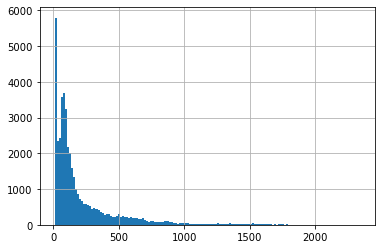

In [55]:
result_df.length.hist(bins=150)

In [62]:
np.round(result_df.reps[0], 4)

array([0.5375, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964,
       0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964, 0.4964,
       0.4964, 0.4964, 0.4964, 0.4964, 0.4994, 0.5066, 0.4994, 0.4994,
       0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994,
       0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994, 0.4994,
       0.4979, 0.4979, 0.5221, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979,
       0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979, 0.4979,
       0.4979, 0.4979, 0.4979, 0.4979, 0.4977, 0.4977, 0.4977, 0.5243,
       0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977,
       0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977, 0.4977,
       0.4981, 0.4981, 0.4981, 0.4981, 0.5199, 0.4981, 0.4981, 0.4981,
       0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981, 0.4981,
       0.4981, 0.4981, 0.4981, 0.4981, 0.4972, 0.4972, 0.4972, 0.4972,
       0.4972, 0.5287, 0.4972, 0.4972, 0.4972, 0.4972, 0.4972, 0.4972,
      

## solution 2 padding

--> https://www.nature.com/articles/s41598-020-71450-8